In [2]:
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# pytorch 기초

pytorch의 장점은 backword를 자체적으로 수행할 수 있다는 것입니다.

아래의 코드는 2차원 데이터로 2차원의 weight와 1개의 bias 계산하는 예제입니다.

- (requires_grad=True) 가 설정된 tensor들은 자동으로 gradiant를 계산하고 저장합니다.

- loss_function을 통해 구해진 값에 대하여 .backword()를 수행하면 gradiant를 계산하게 됩니다.


In [4]:
import torch

X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

# Initialize weights and bias with requires_grad=True
w = torch.tensor([[0.0], [0.0]], dtype=torch.float32,requires_grad=True)
b = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)
def forward(X):
    return torch.matmul(X, w) + b

def loss(Y, Y_pred):
    return ((Y_pred - Y) ** 2).mean()

learning_rate = 0.01
n_iters = 100

for epoch in range(n_iters):
    Y_pred = forward(X)
    l = loss(Y, Y_pred)

    # gradiant 초기화
    w.grad = None
    b.grad = None

    # backward pass
    l.backward()

    # weights와 bias 업데이트
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {l.item()}')

print("Trained weights:", w)
print("Trained bias:", b)

Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.182020902633667
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.14805902540683746
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.1290162056684494
Epoch 91, Loss: 0.12043382972478867
Trained weights: tensor([[0.8717],
        [0.8450]], requires_grad=True)
Trained bias: tensor([-0.0267], requires_grad=True)


아래의 예시는 위와 동일한 코드이지만, 편하게 사용할 수 있는 함수들입니다.

- 각 대응되는 부분들을 확인해보세요

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
# Define the data
X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

initial_weight = torch.tensor([[0.0, 0.0]], dtype=torch.float32)
initial_bias = torch.tensor([0.0], dtype=torch.float32)


LinearModel = nn.Linear(in_features=2, out_features=1, bias=True)  # linear layer
LinearModel.weight.data = initial_weight.clone() #동일한 결과를 위해 동일하게 초기화
LinearModel.bias.data = initial_bias.clone() #동일한 결과를 위해 동일하게 초기화


criterion = nn.MSELoss() # loss fucntion 정의


optimizer = optim.SGD(LinearModel.parameters(), lr=0.01) # optimizer 정의

# Training loop
n_iters = 100
for epoch in range(n_iters):

    Y_pred = LinearModel(X)


    loss = criterion(Y_pred, Y)

    optimizer.zero_grad() # gradiant 초기화
    loss.backward() # backword process
    optimizer.step() # weight (&bias) update

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


trained_weight, trained_bias = LinearModel.weight.data, LinearModel.bias.data
print("Trained weights:", trained_weight)
print("Trained bias:", trained_bias)


Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.18202082812786102
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.1480589509010315
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.12901611626148224
Epoch 91, Loss: 0.12043388187885284
Trained weights: tensor([[0.8717, 0.8450]])
Trained bias: tensor([-0.0267])


#### GPU 사용

- 런타임 > 런타임 유형변경 > GPU 선택
- .to() method를 사용하여 GPU로 모델과 데이터를 올릴 수 있음
- .cuda() 를 사용하는 것도 가능


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LinearModel.to(device) # GPU로 올리기
print(LinearModel)

Linear(in_features=2, out_features=1, bias=True)


In [8]:
X = X.to(device) # data도 GPU로 올려야 연산 가능함

In [ ]:
LinearModel(X)

tensor([[2.5349],
        [4.2516],
        [5.9683],
        [7.6850]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
LinearModel.cpu() # 다시 CPU로
X.cpu()

tensor([[1., 2.],
        [2., 3.],
        [3., 4.],
        [4., 5.]])

# 문제 1


- MNIST Dataset을 활용하여 손글씨 이미지(숫자)를 예측하는 모델을 만드세요.
- 해당 데이터는 0~9까지의 숫자를 가지고 있습니다.

In [9]:
# Load training data
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import random_split

MNIST 데이터를 데이터 로더에 넣어서 사용하면 미니 배치 단위로 꺼내 쓸 수 있습니다.

In [10]:
training_data = datasets.MNIST(
    root="data",
    train=True, # training data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

val_size = 5000
train_size = len(training_data) - val_size
training_data, val_data = random_split(training_data, [train_size, val_size])

# Load test data
test_data = datasets.MNIST(
    root="data",
    train=False, # test data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

# data loader
# train, test 각각의 data loader 생성
smaple_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11721317.16it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 349502.14it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3218217.46it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2981303.41it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [11]:
# train feature와 label을 train_loader로부터 가져오기
sample_features, sample_labels = next(iter(smaple_loader))
print(f"Feature batch shape: {sample_features.size()}")
print(f"Labels batch shape: {sample_labels.size()}")

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1])


#### 이미지로 확인

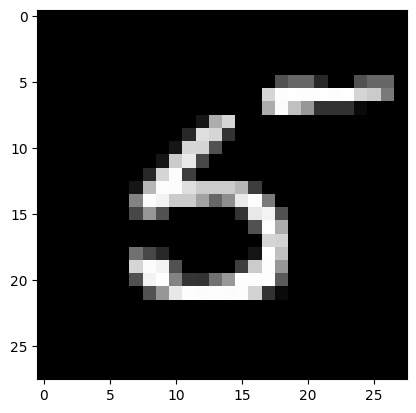

Label: 5


In [ ]:
img = sample_features[0].squeeze()
label = sample_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 문제 1-1

MNIST 데이터셋을 아래의 조건에 따라 학습시키세요.

Fully connected layer (multi layer perceptron)로 NeuralNetwork를 아래의 조건에 맞게 완성하세요.

 - NeuralNetwork 모델 구축
    - 3개의 linear layer와 2개의 ReLU layer를 사용하세요.
    - nn.Linear, nn.ReLU
    - 각 layer의 hidden dimension size는 자유롭게 설정합니다.

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten() # 28x28 이미지를 784 픽셀 값의 배열로 변경
        self.linear_relu_stack = nn.Sequential(
            # 3개의 linear layer와 2개의 ReLU layer를 구성하세요
        #===================================================
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
        #===================================================#

        )

    def forward(self, x):
        # forward 함수 구현
        #===================================================#
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        #===================================================#
        return logits # forward 결과 저장

## 문제 1-2

위에서 만든 NeuralNetwork 모델을 학습시키세요.
train과 test함수를 만들세요.

- CrossEntropy 사용 (nn.CrossEntropyLoss)
- Epoch : 10, batch size : 32
- validation 정확도 90% 이상

In [13]:
# hyperparameter 설정
import torch.optim as optim
FcModel = NeuralNetwork()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(FcModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches

# data loader의 batch size을 16로 변경
train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

In [14]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================
        data_, target_ = data_.to(device), target_.to(device)

        output = model(data_)
        loss = loss_fn(output, target_)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(output, 1)
        epoch_correct += (predicted == target_).sum().item()

        #===================================================#

    if lr_scheduler != None:
        lr_scheduler.step()

    return epoch_correct/size , epoch_loss / num_batches

In [15]:
def test(dataloader , model , loss_fn):
    size = len(dataloader.dataset)
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            data_, target_ = data_.to(device), target_.to(device)

            output = model(data_)
            loss = loss_fn(output, target_)

            epoch_loss += loss.item()
            _, predicted = torch.max(output, 1)
            epoch_correct += (predicted == target_).sum().item()
            #========================================#

    return epoch_correct/size  , epoch_loss / num_baches

In [ ]:
FcModel.cuda()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [16]:
# 체크포인트 디렉토리 생성
os.makedirs("checkpoints", exist_ok=True)

In [ ]:
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   FcModel ,
                                   criterion ,
                                   optimizer )

    val_acc , val_loss = test(val_loader , FcModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "checkpoints/NN_best.pth")


## 결과



```
#
10%|█         | 1/10 [00:20<03:03, 20.36s/it]epoch:0     train_loss = 1.2165 , train_acc:0.6812     val_loss = 0.4711 , val_acc:0.8680     learning rate: 0.001
 20%|██        | 2/10 [00:33<02:07, 15.91s/it]epoch:1     train_loss = 0.4035 , train_acc:0.8855     val_loss = 0.3410 , val_acc:0.9014     learning rate: 0.001
 30%|███       | 3/10 [00:44<01:36, 13.82s/it]epoch:2     train_loss = 0.3267 , train_acc:0.9074     val_loss = 0.2948 , val_acc:0.9144     learning rate: 0.001
 40%|████      | 4/10 [00:55<01:15, 12.61s/it]epoch:3     train_loss = 0.2848 , train_acc:0.9178     val_loss = 0.2632 , val_acc:0.9204     learning rate: 0.001
 50%|█████     | 5/10 [01:06<01:00, 12.00s/it]epoch:4     train_loss = 0.2540 , train_acc:0.9273     val_loss = 0.2336 , val_acc:0.9318     learning rate: 0.001
 60%|██████    | 6/10 [01:16<00:45, 11.35s/it]epoch:5     train_loss = 0.2283 , train_acc:0.9347     val_loss = 0.2124 , val_acc:0.9372     learning rate: 0.001
 70%|███████   | 7/10 [01:28<00:34, 11.65s/it]epoch:6     train_loss = 0.2059 , train_acc:0.9416     val_loss = 0.1962 , val_acc:0.9434     learning rate: 0.001
 80%|████████  | 8/10 [01:45<00:26, 13.20s/it]epoch:7     train_loss = 0.1874 , train_acc:0.9460     val_loss = 0.1843 , val_acc:0.9438     learning rate: 0.001
 90%|█████████ | 9/10 [01:55<00:12, 12.31s/it]epoch:8     train_loss = 0.1712 , train_acc:0.9510     val_loss = 0.1714 , val_acc:0.9502     learning rate: 0.001
100%|██████████| 10/10 [02:08<00:00, 12.83s/it]epoch:9     train_loss = 0.1575 , train_acc:0.9542     val_loss = 0.1587 , val_acc:0.9534     learning rate: 0.001

```



# 문제 1-3 : CNN

- CNN 모델을 아래의 조건과 같이 구축하여 학습하시오.
- validation 정확도 90% 이상

아래의 조건을 만족하는 CNN model을 만드시오.


 - CNN layer 1 - filter 수 32, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 2 - filter 수 64, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 3 - filter 수 128, filter size : 3,
 - Max pooling : 2 x 2
 - Fc layer 1 : last Cnn feature size (flatten) -> 128
 - ReLU ()
 - Fc layer 2 : 128 -> 64
 - ReLU ()
 - Fc layer 3 : 64 -> 10

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        #===============================================
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        #===============================================#


    def forward(self, x):

        #===============================================#
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 3 * 3)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #===============================================#

        return x

In [18]:
# hyperparameter 설정
import torch.optim as optim
SimModel = SimpleCNN()
SimModel.to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(SimModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches


train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   SimModel ,
                                   criterion ,
                                   optimizer )

    val_acc , val_loss = test(val_loader , SimModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "checkpoints/Simple_CNN_best.pth")


## 결과



```
#
10%|█         | 1/10 [00:20<03:04, 20.50s/it]epoch:0     train_loss = 2.2727 , train_acc:0.2053     val_loss = 1.9774 , val_acc:0.4350     learning rate: 0.001
 20%|██        | 2/10 [00:36<02:21, 17.75s/it]epoch:1     train_loss = 0.5488 , train_acc:0.8249     val_loss = 0.2010 , val_acc:0.9344     learning rate: 0.001
 30%|███       | 3/10 [00:53<02:01, 17.37s/it]epoch:2     train_loss = 0.1569 , train_acc:0.9512     val_loss = 0.1131 , val_acc:0.9630     learning rate: 0.001
 40%|████      | 4/10 [01:08<01:40, 16.67s/it]epoch:3     train_loss = 0.1036 , train_acc:0.9675     val_loss = 0.0752 , val_acc:0.9762     learning rate: 0.001
 50%|█████     | 5/10 [01:23<01:20, 16.02s/it]epoch:4     train_loss = 0.0825 , train_acc:0.9738     val_loss = 0.0715 , val_acc:0.9766     learning rate: 0.001
 60%|██████    | 6/10 [01:37<01:00, 15.10s/it]epoch:5     train_loss = 0.0707 , train_acc:0.9776     val_loss = 0.0524 , val_acc:0.9844     learning rate: 0.001
 70%|███████   | 7/10 [01:50<00:43, 14.53s/it]epoch:6     train_loss = 0.0610 , train_acc:0.9809     val_loss = 0.0495 , val_acc:0.9842     learning rate: 0.001
 80%|████████  | 8/10 [02:03<00:28, 14.14s/it]epoch:7     train_loss = 0.0534 , train_acc:0.9836     val_loss = 0.0532 , val_acc:0.9826     learning rate: 0.001
 90%|█████████ | 9/10 [02:18<00:14, 14.36s/it]epoch:8     train_loss = 0.0494 , train_acc:0.9840     val_loss = 0.0435 , val_acc:0.9846     learning rate: 0.001
100%|██████████| 10/10 [02:31<00:00, 15.19s/it]epoch:9     train_loss = 0.0443 , train_acc:0.9862     val_loss = 0.0514 , val_acc:0.9830     learning rate: 0.001
```



# Smoke image dataset


- 본 데이터셋은 흡연자의 모습과 비흡자의 모습이 담긴 이미지 파일입니다.
- 이미지 파일을 python으로 가져오기 위해서 다음 과정을 수행합니다.



1.   이미지가 있는 file path를 pandas DataFrame에 label과 함께 저장
2.   데이터 로드를 효율적으로 하기 위해서, 학습 배치마다 해당 path의 이미지를 불러옴



In [19]:
from PIL import Image
from glob import glob

In [20]:
data_path = "/content/drive/My Drive/smoke"

In [21]:
import pandas as pd
import os
from glob import glob

def create_dataframe(data_path, label_list, data_type):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    img_list = glob(os.path.join(data_path, '*.jpg'))

    for img in img_list:
        file_name = os.path.splitext(img)[0].split("/")[-1]
        if file_name[0:len(label_list[0])] == label_list[0]:
            new_data =pd.DataFrame({"path":img,"label":label_list[0], "class_id":0}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)
        elif file_name[0:len(label_list[1])] == label_list[1]:
            new_data =pd.DataFrame({"path":img,"label":label_list[1], "class_id":1}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)

    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)

    return df

In [22]:
# Example usage:
train_path = data_path + '/Training/Training/'
valid_path = data_path + '/Validation/Validation/'
test_path = data_path + '/Testing/Testing/'
label_list = ['notsmoking', 'smoking']

train_df = create_dataframe(train_path, label_list, 'training')
val_df = create_dataframe(valid_path, label_list, 'validation')
test_df = create_dataframe(test_path, label_list, 'test')

In [23]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")
print(f"test_data:{len(test_df)}")

train_data: 716
val_data:180
test_data:224


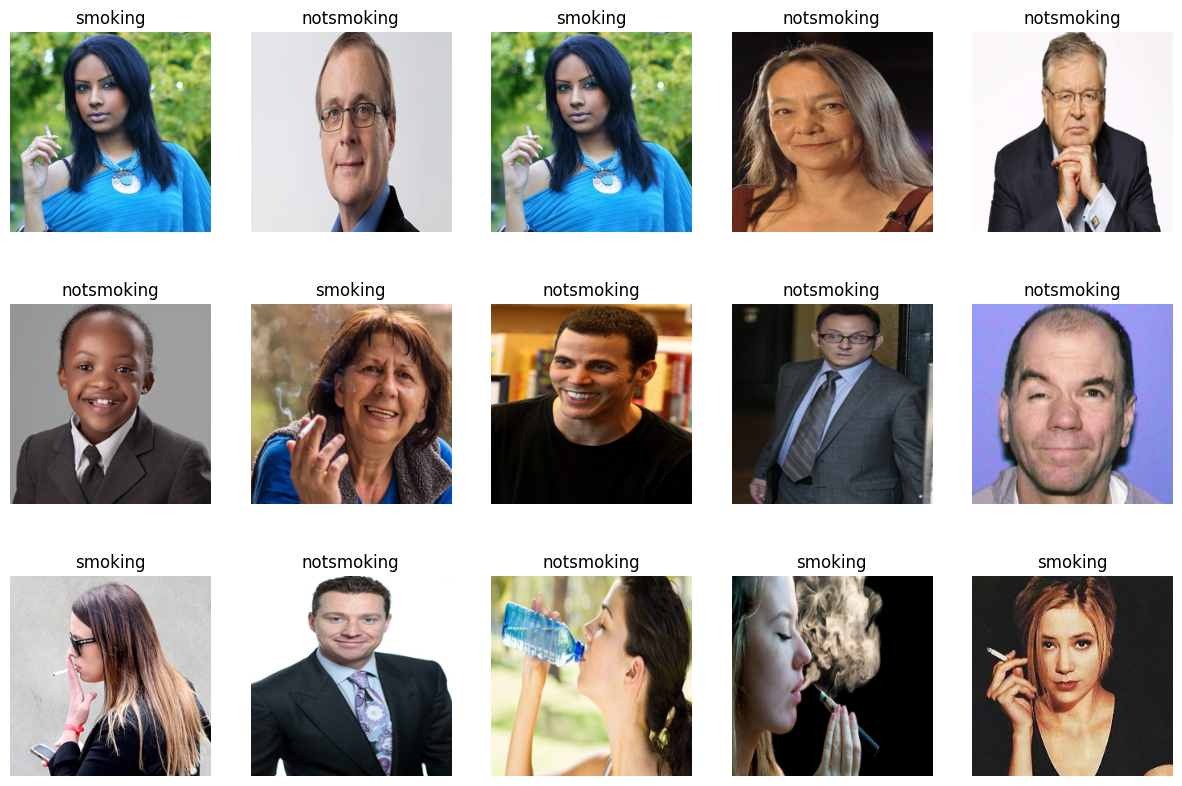

In [24]:
show_imgs = 15
idx = np.random.randint(0,len(val_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Dataset & Dataloader

Pytorch의 Dataset & Dataloader은, 데이터를 다루고 모델을 훈련 및 시험하기 위하여 가장 주의를 기울여야 될 부분 중의 하나입니다.

Dataset은 전체 데이터에서 특정 데이터를 꺼내오는 역할 및 전처리나 augmentation, 추가적인 function 처리를 효율적으로 할 수 있도록 합니다.
Dataloader의 경우, Dataset을 Minibatch 형태로 만들어 주며, Batch size나, Shuffle 여부에 대한 것들을 설정할 수 있습니다.

자세한 사항은 아래의 링크를 확인해보시기 바랍니다.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [25]:
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [26]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self , dataframe , transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self ,index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img , class_id

In [27]:
SimpleTransforms = v2.Compose([
    v2.Resize((224,224)), # image 크기 맞추기
    v2.PILToTensor(), # torch.tensor로 변환
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]) # dtype 변환

In [28]:
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
example_dataset = BaseDataset(train_df , SimpleTransforms) # train_transforms
example_loader = DataLoader(example_dataset , batch_size=BATCH_SIZE , shuffle = True)

In [ ]:
img, class_id = next(iter(example_dataset))

In [ ]:
img.shape # (batch, channel, W, H)

torch.Size([3, 224, 224])

In [ ]:
img, class_id = next(iter(example_loader))

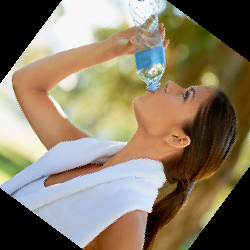

In [ ]:
# augmentation 참고
# https://pytorch.org/vision/main/transforms.html

rotation_transform = v2.RandomRotation(degrees=90) # compose에 추가 가능
image = Image.open(full_path)
rotated_image = rotation_transform(image)
rotated_image


# 문제 2

 1-3의 모델을 **layer를 추가하지 않고**, 아래의 조건을 토대로 성능을
 향상시켜보세요.


 - batch norm, dropout 둘 다 적용
 - data augmentation 기법 1가지 이상 추가
 - layer 자체를 추가하는 것 이외의 다른 방법들 추가 적용 가능
    - kernel size 등등
    - max pooling은 layer로 취급하지 않음
    - 이외 추가적인 hyperparameter 변경 가능
    - feature size 당연히, 수정 가능
 - **test acc (75%) 이상 달성**

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
import torch
torch.cuda.empty_cache()


In [31]:
CustomTransforms = v2.Compose([
    #===============================#
    v2.Resize((224,224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    v2.RandomResizedCrop(size=(224,224), scale=(0.8, 1.0)),
    v2.RandomGrayscale(p=0.2),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #===============================#
    ]) # dtype 변환

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [32]:
#get dataloader

train_dataset = BaseDataset(train_df , CustomTransforms) # train_transforms
val_dataset = BaseDataset(val_df , CustomTransforms)
test_dataset = BaseDataset(test_df , CustomTransforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)


        #===============================================#
        # batch norm, drop out 사용

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        #===============================================#

    def forward(self, x):

        #===============================================#
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 128 * 28 * 28)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        #===============================================#

        return x


In [34]:
ImpModel = ImprovedCNN()
ImpModel.cuda()

ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [47]:
EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#==============================
EPOCHS = 120

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RAdam(ImpModel.parameters(), lr=0.001, weight_decay=1e-4)
Cosine_lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

#==============================#

patience = 10
counter = 0
best_loss = np.inf

In [48]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_samples = 0
    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================#
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        output = model(data_).squeeze(1)
        loss = loss_fn(output, target_.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predictions = torch.round(torch.sigmoid(output))
        epoch_correct += (predictions == target_).sum().item()
        #===================================================#

    if lr_scheduler != None:
        lr_scheduler.step()

    return epoch_correct/size , epoch_loss / num_batches

def test(dataloader , model , loss_fn):
    size = len(dataloader.dataset)
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            data_, target_ = data_.to(device), target_.to(device)
            output = model(data_).squeeze(1)
            loss = loss_fn(output, target_.float())

            epoch_loss += loss.item()
            predictions = torch.round(torch.sigmoid(output))
            epoch_correct += (predictions == target_).sum().item()
            #========================================#

    return epoch_correct/size  , epoch_loss / num_baches

In [49]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   ImpModel ,
                                   criterion ,
                                   optimizer ,
                                   Cosine_lr_scheduler)

    val_acc , val_loss = test(val_loader , ImpModel , criterion)
    print(f'epoch:{epoch} \
      train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(ImpModel.state_dict() , "checkpoints/Improved_CNN_best.pth")
    else:
        counter+=1
    if counter >= patience:
        test_acc , val_loss = test(test_loader , ImpModel , criterion)
        print("Early stop !")
        print(test_acc)
        break

  0%|          | 0/120 [00:00<?, ?it/s]

epoch:0       train_loss = 0.5595 , train_acc:0.7053     val_loss = 0.5495 , val_acc:0.7333     learning rate: 0.0009757729755661011


  1%|          | 1/120 [00:17<34:51, 17.57s/it]

epoch:1       train_loss = 0.5591 , train_acc:0.7263     val_loss = 0.5356 , val_acc:0.7056     learning rate: 0.000905463412215599


  2%|▎         | 3/120 [00:52<34:17, 17.59s/it]

epoch:2       train_loss = 0.5522 , train_acc:0.7277     val_loss = 0.5383 , val_acc:0.7167     learning rate: 0.0007959536998847742


  3%|▎         | 4/120 [01:10<33:59, 17.58s/it]

epoch:3       train_loss = 0.5566 , train_acc:0.7291     val_loss = 0.5725 , val_acc:0.7111     learning rate: 0.000657963412215599


  4%|▍         | 5/120 [01:27<33:08, 17.29s/it]

epoch:4       train_loss = 0.5386 , train_acc:0.7179     val_loss = 0.5559 , val_acc:0.7444     learning rate: 0.000505


  5%|▌         | 6/120 [01:43<32:28, 17.10s/it]

epoch:5       train_loss = 0.5676 , train_acc:0.7039     val_loss = 0.5450 , val_acc:0.7500     learning rate: 0.0003520365877844011
epoch:6       train_loss = 0.5751 , train_acc:0.7123     val_loss = 0.5195 , val_acc:0.7333     learning rate: 0.00021404630011522585


  7%|▋         | 8/120 [02:18<32:02, 17.16s/it]

epoch:7       train_loss = 0.5698 , train_acc:0.7332     val_loss = 0.5561 , val_acc:0.7444     learning rate: 0.00010453658778440107


  8%|▊         | 9/120 [02:35<31:41, 17.13s/it]

epoch:8       train_loss = 0.5505 , train_acc:0.7263     val_loss = 0.5362 , val_acc:0.7278     learning rate: 3.4227024433899005e-05


  8%|▊         | 10/120 [02:51<31:03, 16.94s/it]

epoch:9       train_loss = 0.5600 , train_acc:0.7291     val_loss = 0.5336 , val_acc:0.7222     learning rate: 0.001


  9%|▉         | 11/120 [03:08<30:35, 16.84s/it]

epoch:10       train_loss = 0.5833 , train_acc:0.7109     val_loss = 0.5237 , val_acc:0.7556     learning rate: 0.0009939057285945933


 10%|█         | 12/120 [03:24<30:09, 16.75s/it]

epoch:11       train_loss = 0.5965 , train_acc:0.6732     val_loss = 0.5496 , val_acc:0.7389     learning rate: 0.0009757729755661011


 11%|█         | 13/120 [03:43<30:40, 17.20s/it]

epoch:12       train_loss = 0.6248 , train_acc:0.6997     val_loss = 0.5804 , val_acc:0.7000     learning rate: 0.0009460482294732421


 12%|█▏        | 14/120 [04:00<30:35, 17.32s/it]

epoch:13       train_loss = 0.5801 , train_acc:0.7123     val_loss = 0.5660 , val_acc:0.7167     learning rate: 0.000905463412215599


 12%|█▎        | 15/120 [04:17<29:52, 17.07s/it]

epoch:14       train_loss = 0.5714 , train_acc:0.7360     val_loss = 0.5389 , val_acc:0.6722     learning rate: 0.000855017856687341


 13%|█▎        | 16/120 [04:33<29:18, 16.91s/it]

epoch:15       train_loss = 0.5875 , train_acc:0.7165     val_loss = 0.5612 , val_acc:0.7056     learning rate: 0.0007959536998847742
epoch:16       train_loss = 0.5622 , train_acc:0.7332     val_loss = 0.5510 , val_acc:0.7111     learning rate: 0.0007297252973710757


 13%|█▎        | 16/120 [04:54<31:55, 18.42s/it]

Early stop !
0.7767857142857143


# 결과

```
  0%|          | 0/120 [00:00<?, ?it/s]epoch:0       train_loss = 0.5595 , train_acc:0.7053     val_loss = 0.5495 , val_acc:0.7333     learning rate: 0.0009757729755661011
  1%|          | 1/120 [00:17<34:51, 17.57s/it]epoch:1       train_loss = 0.5591 , train_acc:0.7263     val_loss = 0.5356 , val_acc:0.7056     learning rate: 0.000905463412215599
  2%|▎         | 3/120 [00:52<34:17, 17.59s/it]epoch:2       train_loss = 0.5522 , train_acc:0.7277     val_loss = 0.5383 , val_acc:0.7167     learning rate: 0.0007959536998847742
  3%|▎         | 4/120 [01:10<33:59, 17.58s/it]epoch:3       train_loss = 0.5566 , train_acc:0.7291     val_loss = 0.5725 , val_acc:0.7111     learning rate: 0.000657963412215599
  4%|▍         | 5/120 [01:27<33:08, 17.29s/it]epoch:4       train_loss = 0.5386 , train_acc:0.7179     val_loss = 0.5559 , val_acc:0.7444     learning rate: 0.000505
  5%|▌         | 6/120 [01:43<32:28, 17.10s/it]epoch:5       train_loss = 0.5676 , train_acc:0.7039     val_loss = 0.5450 , val_acc:0.7500     learning rate: 0.0003520365877844011
epoch:6       train_loss = 0.5751 , train_acc:0.7123     val_loss = 0.5195 , val_acc:0.7333     learning rate: 0.00021404630011522585
  7%|▋         | 8/120 [02:18<32:02, 17.16s/it]epoch:7       train_loss = 0.5698 , train_acc:0.7332     val_loss = 0.5561 , val_acc:0.7444     learning rate: 0.00010453658778440107
  8%|▊         | 9/120 [02:35<31:41, 17.13s/it]epoch:8       train_loss = 0.5505 , train_acc:0.7263     val_loss = 0.5362 , val_acc:0.7278     learning rate: 3.4227024433899005e-05
  8%|▊         | 10/120 [02:51<31:03, 16.94s/it]epoch:9       train_loss = 0.5600 , train_acc:0.7291     val_loss = 0.5336 , val_acc:0.7222     learning rate: 0.001
  9%|▉         | 11/120 [03:08<30:35, 16.84s/it]epoch:10       train_loss = 0.5833 , train_acc:0.7109     val_loss = 0.5237 , val_acc:0.7556     learning rate: 0.0009939057285945933
 10%|█         | 12/120 [03:24<30:09, 16.75s/it]epoch:11       train_loss = 0.5965 , train_acc:0.6732     val_loss = 0.5496 , val_acc:0.7389     learning rate: 0.0009757729755661011
 11%|█         | 13/120 [03:43<30:40, 17.20s/it]epoch:12       train_loss = 0.6248 , train_acc:0.6997     val_loss = 0.5804 , val_acc:0.7000     learning rate: 0.0009460482294732421
 12%|█▏        | 14/120 [04:00<30:35, 17.32s/it]epoch:13       train_loss = 0.5801 , train_acc:0.7123     val_loss = 0.5660 , val_acc:0.7167     learning rate: 0.000905463412215599
 12%|█▎        | 15/120 [04:17<29:52, 17.07s/it]epoch:14       train_loss = 0.5714 , train_acc:0.7360     val_loss = 0.5389 , val_acc:0.6722     learning rate: 0.000855017856687341
 13%|█▎        | 16/120 [04:33<29:18, 16.91s/it]epoch:15       train_loss = 0.5875 , train_acc:0.7165     val_loss = 0.5612 , val_acc:0.7056     learning rate: 0.0007959536998847742
epoch:16       train_loss = 0.5622 , train_acc:0.7332     val_loss = 0.5510 , val_acc:0.7111     learning rate: 0.0007297252973710757
 13%|█▎        | 16/120 [04:54<31:55, 18.42s/it]Early stop !
0.7767857142857143

```



# 문제 3: Pretrained model
사전 학습된 모델(Pretrained model)을 통해 위의 이미지 데이터를  흡연 여부를 판별고자 합니다.

이를 위해서 모델을 불러오고, 학습 및 검증하여 최종 성능을 평가하시오.

In [54]:
# pretrained 관련
import torch
import torchvision.transforms as v2
from torchvision import models

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 문제 3-1: Pretrained Model (backborn)모델 학습

아래의 `resnet18` 예제를 참고하여, `vgg16`의 pretrained model를 불러와 Smoke 탐지를 진행할 수 있도록 layer를 수정하시오.

- MyVGG16 Class를 완성하시오.
- Vgg16의 CNN layer들은 모두 frozen하시오.
- 추가적인 layer와 다양한 기법들을 추가해도 됩니다.
- **test acc (75%) 이상 달성**
- **(extra) test acc (80%) 이상 달성시 추가 점수(+1): freeze한 layer fine-tuning 가능**


- https://pytorch.org/vision/stable/models.html 참고

In [57]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


In [ ]:
print(resnet18) # 각 레이어의 구성을 확인

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [58]:
Last_layer_hiddensize = resnet18.fc.in_features
resnet18.fc = nn.Linear(Last_layer_hiddensize, 1)

In [59]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 89.6MB/s]


In [60]:
nn.Linear(10,10).requires_grad = False # gradiant 끄기
#nn.Linear(10,10).requires_grad = True # gradiant 켜기

In [61]:

class MyVGG16(nn.Module):
    def __init__(self, pretrained_model):
        super(MyVGG16, self).__init__()
        self.backbone = pretrained_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.flatten = nn.Flatten()
        self.extra_layer = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.extra_layer(x)
        return x


In [62]:
myvgg16 = MyVGG16(vgg16)

## 문제 3-2: Fine-tuning

- `MyVGG16`를 활용하여 Fine-tuning을 진행하시오.

In [63]:
EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#=============================#
# Layer freezing & Find-tuning
for param in myvgg16.backbone.parameters():
    param.requires_grad = False
for param in myvgg16.extra_layer.parameters():
    param.requires_grad = True

# loss function/optimizer 설정 및 criterion 변경
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, myvgg16.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)
Cosine_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
#==============================#

patience = 10
counter = 0
best_loss = np.inf

In [64]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================
        data, target = data_.to(device), target_.to(device).float()
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        predictions = torch.round(torch.sigmoid(output))
        epoch_correct += (predictions == target.unsqueeze(1)).sum().item()
        #===================================================#


    train_acc = epoch_correct / size
    lr_scheduler.step()

    return train_acc , epoch_loss / num_batches


def test(dataloader , model , loss_fn):
    size = len(dataloader.dataset)
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            data, target = data_.to(device), target_.to(device).float()
            output = model(data)
            loss = loss_fn(output, target.unsqueeze(1))
            epoch_loss += loss.item()
            predictions = torch.round(torch.sigmoid(output))
            epoch_correct += (predictions == target.unsqueeze(1)).sum().item()
            #========================================#

    test_acc = epoch_correct/size

    return test_acc  , epoch_loss / num_baches


In [65]:
myvgg16.cuda()

MyVGG16(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader,
                                  myvgg16,
                                  criterion,
                                  optimizer,
                                  Cosine_lr_scheduler)

    val_acc, val_loss = test(val_loader, myvgg16, criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f}, train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f}, val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(myvgg16.state_dict(), "checkpoints/myvgg_16_best.pth")
    else:
        counter += 1

    if counter >= patience:
        test_acc, test_loss = test(test_loader, myvgg16, criterion)
        print("Early stop!")
        print(test_acc)
        break


  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0     train_loss = 0.6843, train_acc:0.5391     val_loss = 0.6339, val_acc:0.5833     learning rate: 0.0009997532801828658


  1%|          | 1/100 [00:20<33:12, 20.13s/it]

epoch:1     train_loss = 0.6066, train_acc:0.7067     val_loss = 0.5206, val_acc:0.8167     learning rate: 0.0009990133642141358


  2%|▏         | 2/100 [00:40<33:25, 20.47s/it]

epoch:2     train_loss = 0.5170, train_acc:0.7709     val_loss = 0.4030, val_acc:0.8222     learning rate: 0.00099778098230154


  3%|▎         | 3/100 [01:00<32:31, 20.12s/it]

epoch:3     train_loss = 0.4420, train_acc:0.8087     val_loss = 0.3319, val_acc:0.8333     learning rate: 0.000996057350657239


  4%|▍         | 4/100 [01:21<32:49, 20.52s/it]

epoch:4     train_loss = 0.4129, train_acc:0.8156     val_loss = 0.3163, val_acc:0.8944     learning rate: 0.0009938441702975688


  5%|▌         | 5/100 [01:42<32:47, 20.71s/it]

epoch:5     train_loss = 0.3788, train_acc:0.8408     val_loss = 0.3006, val_acc:0.8444     learning rate: 0.0009911436253643444


  7%|▋         | 7/100 [02:24<32:00, 20.65s/it]

epoch:6     train_loss = 0.3875, train_acc:0.8408     val_loss = 0.4778, val_acc:0.7722     learning rate: 0.0009879583809693736


  8%|▊         | 8/100 [02:43<30:36, 19.96s/it]

epoch:7     train_loss = 0.3775, train_acc:0.8212     val_loss = 0.3180, val_acc:0.8611     learning rate: 0.0009842915805643154


  9%|▉         | 9/100 [03:01<29:13, 19.27s/it]

epoch:8     train_loss = 0.3955, train_acc:0.8073     val_loss = 0.3190, val_acc:0.8278     learning rate: 0.0009801468428384714
epoch:9     train_loss = 0.3519, train_acc:0.8408     val_loss = 0.2860, val_acc:0.8611     learning rate: 0.0009755282581475767


 11%|█         | 11/100 [03:52<32:42, 22.05s/it]

epoch:10     train_loss = 0.3130, train_acc:0.8729     val_loss = 0.3137, val_acc:0.8278     learning rate: 0.0009704403844771127


 12%|█▏        | 12/100 [04:11<30:47, 20.99s/it]

epoch:11     train_loss = 0.2914, train_acc:0.8785     val_loss = 0.3068, val_acc:0.8611     learning rate: 0.0009648882429441257


 13%|█▎        | 13/100 [04:29<29:16, 20.19s/it]

epoch:12     train_loss = 0.3170, train_acc:0.8589     val_loss = 0.3566, val_acc:0.8167     learning rate: 0.0009588773128419905


 14%|█▍        | 14/100 [04:48<28:27, 19.86s/it]

epoch:13     train_loss = 0.3059, train_acc:0.8715     val_loss = 0.3541, val_acc:0.8556     learning rate: 0.0009524135262330098


 15%|█▌        | 15/100 [05:06<27:16, 19.25s/it]

epoch:14     train_loss = 0.3197, train_acc:0.8743     val_loss = 0.3535, val_acc:0.8278     learning rate: 0.0009455032620941839


 16%|█▌        | 16/100 [05:24<26:27, 18.90s/it]

epoch:15     train_loss = 0.2701, train_acc:0.8911     val_loss = 0.3499, val_acc:0.8278     learning rate: 0.0009381533400219318


 17%|█▋        | 17/100 [05:43<26:03, 18.83s/it]

epoch:16     train_loss = 0.2865, train_acc:0.8855     val_loss = 0.3037, val_acc:0.8333     learning rate: 0.0009303710135019719


 18%|█▊        | 18/100 [06:01<25:21, 18.55s/it]

epoch:17     train_loss = 0.2594, train_acc:0.9008     val_loss = 0.3155, val_acc:0.8444     learning rate: 0.0009221639627510076


 19%|█▉        | 19/100 [06:18<24:45, 18.34s/it]

epoch:18     train_loss = 0.2740, train_acc:0.8785     val_loss = 0.3582, val_acc:0.8333     learning rate: 0.000913540287137281
epoch:19     train_loss = 0.2628, train_acc:0.8911     val_loss = 0.3455, val_acc:0.8444     learning rate: 0.0009045084971874739


 19%|█▉        | 19/100 [06:41<28:31, 21.13s/it]

Early stop!
0.8571428571428571


# **결과**



```
  0%|          | 0/100 [00:00<?, ?it/s]epoch:0     train_loss = 0.6843, train_acc:0.5391     val_loss = 0.6339, val_acc:0.5833     learning rate: 0.0009997532801828658
  1%|          | 1/100 [00:20<33:12, 20.13s/it]epoch:1     train_loss = 0.6066, train_acc:0.7067     val_loss = 0.5206, val_acc:0.8167     learning rate: 0.0009990133642141358
  2%|▏         | 2/100 [00:40<33:25, 20.47s/it]epoch:2     train_loss = 0.5170, train_acc:0.7709     val_loss = 0.4030, val_acc:0.8222     learning rate: 0.00099778098230154
  3%|▎         | 3/100 [01:00<32:31, 20.12s/it]epoch:3     train_loss = 0.4420, train_acc:0.8087     val_loss = 0.3319, val_acc:0.8333     learning rate: 0.000996057350657239
  4%|▍         | 4/100 [01:21<32:49, 20.52s/it]epoch:4     train_loss = 0.4129, train_acc:0.8156     val_loss = 0.3163, val_acc:0.8944     learning rate: 0.0009938441702975688
  5%|▌         | 5/100 [01:42<32:47, 20.71s/it]epoch:5     train_loss = 0.3788, train_acc:0.8408     val_loss = 0.3006, val_acc:0.8444     learning rate: 0.0009911436253643444
  7%|▋         | 7/100 [02:24<32:00, 20.65s/it]epoch:6     train_loss = 0.3875, train_acc:0.8408     val_loss = 0.4778, val_acc:0.7722     learning rate: 0.0009879583809693736
  8%|▊         | 8/100 [02:43<30:36, 19.96s/it]epoch:7     train_loss = 0.3775, train_acc:0.8212     val_loss = 0.3180, val_acc:0.8611     learning rate: 0.0009842915805643154
  9%|▉         | 9/100 [03:01<29:13, 19.27s/it]epoch:8     train_loss = 0.3955, train_acc:0.8073     val_loss = 0.3190, val_acc:0.8278     learning rate: 0.0009801468428384714
epoch:9     train_loss = 0.3519, train_acc:0.8408     val_loss = 0.2860, val_acc:0.8611     learning rate: 0.0009755282581475767
 11%|█         | 11/100 [03:52<32:42, 22.05s/it]epoch:10     train_loss = 0.3130, train_acc:0.8729     val_loss = 0.3137, val_acc:0.8278     learning rate: 0.0009704403844771127
 12%|█▏        | 12/100 [04:11<30:47, 20.99s/it]epoch:11     train_loss = 0.2914, train_acc:0.8785     val_loss = 0.3068, val_acc:0.8611     learning rate: 0.0009648882429441257
 13%|█▎        | 13/100 [04:29<29:16, 20.19s/it]epoch:12     train_loss = 0.3170, train_acc:0.8589     val_loss = 0.3566, val_acc:0.8167     learning rate: 0.0009588773128419905
 14%|█▍        | 14/100 [04:48<28:27, 19.86s/it]epoch:13     train_loss = 0.3059, train_acc:0.8715     val_loss = 0.3541, val_acc:0.8556     learning rate: 0.0009524135262330098
 15%|█▌        | 15/100 [05:06<27:16, 19.25s/it]epoch:14     train_loss = 0.3197, train_acc:0.8743     val_loss = 0.3535, val_acc:0.8278     learning rate: 0.0009455032620941839
 16%|█▌        | 16/100 [05:24<26:27, 18.90s/it]epoch:15     train_loss = 0.2701, train_acc:0.8911     val_loss = 0.3499, val_acc:0.8278     learning rate: 0.0009381533400219318
 17%|█▋        | 17/100 [05:43<26:03, 18.83s/it]epoch:16     train_loss = 0.2865, train_acc:0.8855     val_loss = 0.3037, val_acc:0.8333     learning rate: 0.0009303710135019719
 18%|█▊        | 18/100 [06:01<25:21, 18.55s/it]epoch:17     train_loss = 0.2594, train_acc:0.9008     val_loss = 0.3155, val_acc:0.8444     learning rate: 0.0009221639627510076
 19%|█▉        | 19/100 [06:18<24:45, 18.34s/it]epoch:18     train_loss = 0.2740, train_acc:0.8785     val_loss = 0.3582, val_acc:0.8333     learning rate: 0.000913540287137281
epoch:19     train_loss = 0.2628, train_acc:0.8911     val_loss = 0.3455, val_acc:0.8444     learning rate: 0.0009045084971874739
 19%|█▉        | 19/100 [06:41<28:31, 21.13s/it]Early stop!
0.8571428571428571

```



# 문제 4: 최종 결과 비교

- 각 BEST 모델을 불러오고 성능 비교 (ImprovedCNN best,VGG16 best)

In [51]:
model_state_dict = torch.load("checkpoints/Improved_CNN_best.pth")
ImpCNN = ImprovedCNN()
ImpCNN.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:
model_state_dict = torch.load("checkpoints/myvgg_16_best.pth")
myvgg16 = MyVGG16()
myvgg16.load_state_dict(model_state_dict)

In [ ]:
#=================================#
imp_test_acc = 0.7767857142857143
vgg_test_acc = 0.8571428571428571
#=================================#
print(f"ImpCNN {imp_test_acc}")
print(f"MyVgg16 {vgg_test_acc}")